In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#cd drive/My Drive/Recsys-2019/image_caption_gen

/content/drive/My Drive/Recsys-2019/image_caption_gen


In [0]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, GRU, Embedding, TimeDistributed, Dense, RepeatVector, Add, Lambda,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "data/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [0]:
def load_descriptions(doc):
  
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
    
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [0]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [0]:
descriptions['990890291_afc72be141']

['A man does a wheelie on his bicycle on the sidewalk .',
 'A man is doing a wheelie on a mountain bike .',
 'A man on a bicycle is on only the back wheel .',
 'Asian man in orange hat is popping a wheelie on his bike .',
 'Man on a bicycle riding on only one wheel .']

In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [0]:
descriptions['990890291_afc72be141']

['man does wheelie on his bicycle on the sidewalk',
 'man is doing wheelie on mountain bike',
 'man on bicycle is on only the back wheel',
 'asian man in orange hat is popping wheelie on his bike',
 'man on bicycle riding on only one wheel']

In [0]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'data/descriptions.txt')

In [0]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'data/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [0]:
# load validation dataset (1K)
dev_fn = 'data/Flickr_8k.devImages.txt'
dev = load_set(dev_fn)
print('Validation Dataset: %d' % len(dev))

Validation Dataset: 1000


In [0]:
# load test dataset (1K)
test_fn = 'data/Flickr_8k.testImages.txt'
test = load_set(test_fn)
print('Test Dataset: %d' % len(test))

Test Dataset: 1000


In [0]:
# Below path contains all the images
images = 'data/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [0]:
# Below file conatains the names of images to be used in train data
train_images_file = 'data/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [0]:
# Below file conatains the names of images to be used in validation data
dev_images_file = 'data/Flickr_8k.devImages.txt'
# Read the validation image names in a set# Read the test image names in a set
dev_images = set(open(dev_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
dev_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in dev_images: # Check if the image belongs to test set
        dev_img.append(i) # Add it to the list of test images

In [0]:
# Below file conatains the names of images to be used in test data
test_images_file = 'data/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('data/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [0]:
# descriptions
dev_descriptions = load_clean_descriptions('data/descriptions.txt', dev)
print('Descriptions: validation=%d' % len(dev_descriptions))

Descriptions: validation=1000


In [0]:
# descriptions
test_descriptions = load_clean_descriptions('data/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

### Transfer learning from inception model who had been trained on ImageNet

In [0]:
import _pickle as cPickle

In [0]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 2s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once

'''
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

'''

'\nstart = time()\nencoding_train = {}\nfor img in train_img:\n    encoding_train[img[len(images):]] = encode(img)\nprint("Time taken in seconds =", time()-start)\n\n'

In [0]:
'''

# Save the bottleneck train features to disk
with open("data/encoded_train_images.pkl", "wb") as encoded_pickle:
    cPickle.dump(encoding_train, encoded_pickle)

'''

'\n\n# Save the bottleneck train features to disk\nwith open("data/encoded_train_images.pkl", "wb") as encoded_pickle:\n    cPickle.dump(encoding_train, encoded_pickle)\n\n'

In [0]:
'''
start = time()
encoding_dev = {}
for img in dev_img:
    encoding_dev[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)
'''

'\nstart = time()\nencoding_dev = {}\nfor img in dev_img:\n    encoding_dev[img[len(images):]] = encode(img)\nprint("Time taken in seconds =", time()-start)\n'

In [0]:
'''
# Save the bottleneck train features to disk
with open("data/encoded_dev_images.pkl", "wb") as encoded_pickle:
    cPickle.dump(encoding_dev, encoded_pickle)

'''

'\n# Save the bottleneck train features to disk\nwith open("data/encoded_dev_images.pkl", "wb") as encoded_pickle:\n    cPickle.dump(encoding_dev, encoded_pickle)\n\n'

In [0]:
'''
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)
'''

'\n# Call the funtion to encode all the test images - Execute this only once\nstart = time()\nencoding_test = {}\nfor img in test_img:\n    encoding_test[img[len(images):]] = encode(img)\nprint("Time taken in seconds =", time()-start)\n'

In [0]:
'''
# Save the bottleneck test features to disk
with open("data/encoded_test_images.pkl", "wb") as encoded_pickle:
    cPickle.dump(encoding_test, encoded_pickle)
'''

'\n# Save the bottleneck test features to disk\nwith open("data/encoded_test_images.pkl", "wb") as encoded_pickle:\n    cPickle.dump(encoding_test, encoded_pickle)\n'

In [0]:
train_features = load(open("data/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [0]:
dev_features = load(open("data/encoded_dev_images.pkl", "rb"))
print('Photos: dev=%d' % len(dev_features))

Photos: dev=1000


In [0]:
test_features = load(open("data/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


In [0]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [0]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))


preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [0]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [0]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# Load Glove vectors
glove_dir = 'data'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 300

# Get 300-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(1652, 300)

In [0]:
max_length # max sequence length of caption

34

### caption

In [0]:
len(train_descriptions)

6000

In [0]:
train_descriptions['990890291_afc72be141']

['startseq man does wheelie on his bicycle on the sidewalk endseq',
 'startseq man is doing wheelie on mountain bike endseq',
 'startseq man on bicycle is on only the back wheel endseq',
 'startseq asian man in orange hat is popping wheelie on his bike endseq',
 'startseq man on bicycle riding on only one wheel endseq']

### features (vector) of images

In [0]:
len(train_features)

6000

In [0]:
train_features['990890291_afc72be141.jpg']

array([0.00971352, 0.23514068, 0.35254997, ..., 0.05749111, 0.90892905,
       0.36450002], dtype=float32)

In [0]:
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical

### Model architecture

In [0]:
# image input
image_in = Input(shape=(2048,), name='image_inputs') # feature from inception net has dimension (, 2048)
fe1 = Dropout(0.5, name='dropout_img_feats')(image_in)
fe2 = Dense(300, activation='relu', name = 'dense_img_feats')(fe1) # reduce the dimension into 300 with FC projection

# caption input
cap_in = Input(shape=(None,),name='caption_inputs') # as input for RNN, with dimension (, None) ; we set it into None since we will re-use the model it in inference stage (need a variable lengh of inputs)
embed_cap = Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], trainable = False) # with dimension (, None, embedding_dim)
se1 = embed_cap(cap_in)
drop_cap = Dropout(0.5)
se2 = drop_cap(se1)
lstm_layer = LSTM(300)
se3 = lstm_layer(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(300, activation='relu')
dense_decoder = decoder2(decoder1)
pred_layer = Dense(vocab_size, activation='softmax')
outputs = pred_layer(dense_decoder)

model = Model(inputs=[image_in, cap_in], outputs=outputs)

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caption_inputs (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
image_inputs (InputLayer)       (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    495600      caption_inputs[0][0]             
__________________________________________________________________________________________________
dropout_img_feats (Dropout)     (None, 2048)         0           image_inputs[0][0]               
__________________________________________________________________________________________________
dropout_1 

### Compile model

In [0]:
adam = optimizers.Adam(lr=0.001)

In [0]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
  
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [0]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_' + str(i) + '.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
2000/2000 [==============================] - 95s 47ms/step - loss: 4.0079 - acc: 0.2538
Epoch 1/1
2000/2000 [==============================] - 90s 45ms/step - loss: 3.3191 - acc: 0.3056
Epoch 1/1
2000/2000 [==============================] - 92s 46ms/step - loss: 3.1073 - acc: 0.3238
Epoch 1/1
2000/2000 [==============================] - 89s 45ms/step - loss: 2.9745 - acc: 0.3354
Epoch 1/1
2000/2000 [==============================] - 89s 45ms/step - loss: 2.8738 - acc: 0.3457
Epoch 1/1
2000/2000 [==============================] - 91s 45ms/step - loss: 2.7936 - acc: 0.3524
Epoch 1/1
2000/2000 [==============================] - 90s 45ms/step - loss: 2.7329 - acc: 0.3583
Epoch 1/1
2000/2000 [==============================] - 90s 45ms/step - loss: 2.6764 - acc: 0.3652
Epoch 1/1
2000/2000 [==============================] - 90s 45ms/step - loss: 2.6310 - acc: 0.3700
Epoch 1/1
2000/2000 [==============================] - 89s 45ms/step -

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 89s 45ms/step - loss: 2.5595 - acc: 0.3775
Epoch 1/1
2000/2000 [==============================] - 89s 45ms/step - loss: 2.5304 - acc: 0.3813
Epoch 1/1
2000/2000 [==============================] - 90s 45ms/step - loss: 2.5024 - acc: 0.3848
Epoch 1/1
2000/2000 [==============================] - 90s 45ms/step - loss: 2.4779 - acc: 0.3871
Epoch 1/1
2000/2000 [==============================] - 90s 45ms/step - loss: 2.4597 - acc: 0.3898
Epoch 1/1
2000/2000 [==============================] - 91s 46ms/step - loss: 2.4404 - acc: 0.3915
Epoch 1/1
2000/2000 [==============================] - 90s 45ms/step - loss: 2.4208 - acc: 0.3956
Epoch 1/1
2000/2000 [==============================] - 89s 44ms/step - loss: 2.4043 - acc: 0.3966
Epoch 1/1
2000/2000 [==============================] - 89s 45ms/step - loss: 2.3928 - acc: 0.3980
Epoch 1/1
2000/2000 [==============================] - 91s 46ms/step - loss: 2.3782 - acc: 0.4000


In [0]:
model.load_weights('./model_9.h5')

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

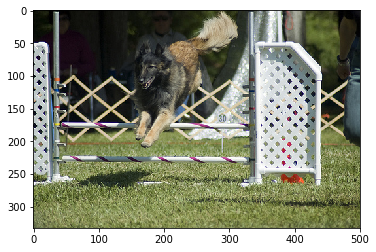

Greedy: dog is jumping over red and white bar


In [0]:
pic = list(test_features.keys())[0]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

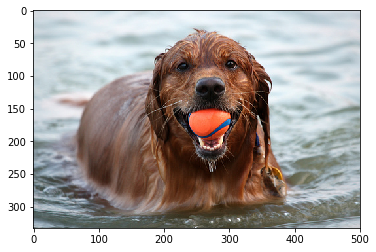

Greedy: dog is running through the water


In [0]:
pic = list(test_features.keys())[30]
image = test_features[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [0]:
def create_decoder_model():
  
  # image features from encoder outputs
  enc_out = Input(shape=(300,), name='')
  
  in_decoder = Input(shape=(None, ))
  
  in_dec_embedded =  embed_cap(in_decoder)
  in_dec_embedded = drop_cap(in_dec_embedded)
  
  enc_cap = lstm_layer(in_dec_embedded)
  
  
  
  x_cap = Reshape((1, 300))(enc_cap)
  x_img = Reshape((1, 300))(enc_out)
  
  context_concat = add([x_cap, x_img])

  
  s = decoder2(context_concat)
  
  softmax_prob = pred_layer(s)
  
  decoder_model = Model([in_decoder] + [enc_out]  , [softmax_prob] )
  
  return decoder_model
  

In [0]:
encoder_model = Model(inputs=image_in, outputs=fe2)

In [0]:
decoder_model = create_decoder_model()

In [0]:
def greedy_generator(in_images):
  
  in_text = 'startseq'
  img_feats = encoder_model.predict(in_images)

  decoded_text = ''
  
  for i in range(max_length):
    
    sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
    sequence = pad_sequences([sequence], maxlen=max_length)
    yhat = decoder_model.predict([sequence, img_feats], verbose=0)
    yhat = np.argmax(yhat)
    word = ixtoword[yhat]
    in_text += ' ' + word
    if word == 'endseq':
        break
        
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final
    

In [0]:
test_img_in = []
test_cap_true = []
img_keys = []
for key, desc_list in test_descriptions.items():
  
  img_vect = test_features[key+'.jpg'].reshape((1,2048))
    
  for desc in desc_list:
       
    test_img_in.append(img_vect)
    test_cap_true.append(desc)
    img_keys.append(key)


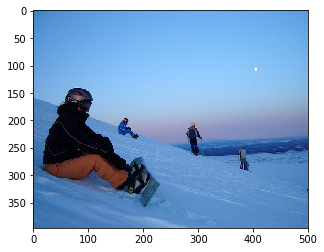

In [0]:
x=plt.imread(images+img_keys[50]+'.jpg')
plt.imshow(x)
plt.show()

In [0]:
greedy_generator(test_img_in[50])

'man in red jacket is standing on the snow near the mountains'

In [0]:
decoding_mode = BeamSearchDecoder(encoder_model=encoder_model, img_inputs=test_img_in[50], decoder_model=decoder_model, indices_words=ixtoword, words_indices=wordtoix, \
                                  decoder_length=34, \
                                  rnn_dim=300, beam_width=4, filepath='./')

In [0]:
import time

In [0]:
decoding_mode.decode()

latest_tokens: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
topk_prob: [0.04532873 0.04170438 0.0390591  0.03528601]
topk_logprob: [3.0938144 3.1771493 3.2426796 3.3442686]
top words : ['man', 'the', 'is', 'person']
topk_prob: [0.04532873 0.04170438 0.0390591  0.03528601]
topk_logprob: [3.0938144 3.1771493 3.2426796 3.3442686]
top words : ['man', 'the', 'is', 'person']
topk_prob: [0.04532873 0.04170438 0.0390591  0.03528601]
topk_logprob: [3.0938144 3.1771493 3.2426796 3.3442686]
top words : ['man', 'the', 'is', 'person']
topk_prob: [0.04532873 0.04170438 0.0390591  0.03528601]
topk_logprob: [3.0938144 3.1771493 3.2426796 3.3442686]
top words : ['man', 'the', 'is', 'person']
topk_prob: [0.04532873 0.04170438 0.0390591  0.03528601]
top